# Shor error correcting code
The Shor error correcting code allows us to correct possible errors given by a noisy channel. We can correct any possible continuous error on one qubit using nine qubits.

In [166]:
!pip install qiskit
!pip install pylatexenc
!pip install qiskit-aer

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit import QuantumRegister, ClassicalRegister, Parameter
from qiskit import transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram

## Encoder

Let's start by defining a quantum circuit to perform the encoding before the
trasmission over the noisy channel.
First we have to perform the phase-flip encoding using two cnot gates controlled by the input and targetting qubits 3 and 6, followed by three hadamard gates on these three current qubits (0,3,6).

Then perform the bit-flip encoding on each one of the last three qubits using other two qubits for each previous one. Thus leading to a final state of nine qubits.

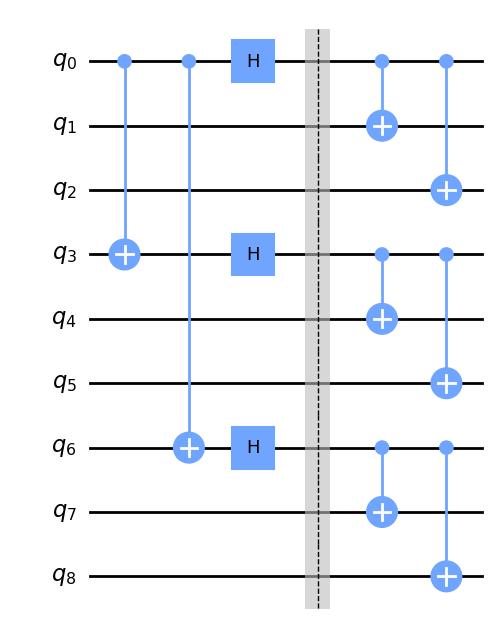

In [167]:
# encoder circuit
encoder = QuantumCircuit(9, name="encoder")
# phase-flip encoder
encoder.cx(0,3)
encoder.cx(0,6)
encoder.h(0)
encoder.h(3)
encoder.h(6)
encoder.barrier(range(9))

# bit-flip encoder
encoder.cx(0,1)
encoder.cx(0,2)
encoder.cx(3,4)
encoder.cx(3,5)
encoder.cx(6,7)
encoder.cx(6,8)

encoder.draw('mpl')

## Decoder

Let's now define the decoder, which will be applied after the noisy channel. First we have to detect and correct the possible bit-flip error in each of the three "blocks". Recall that this circuit supports at most one corrupted qubit.
To achieve this two cnots and a Toffoli Gate have to be used.

Finally, detect the phase-flip by removing the entanglement using an Hadamard gate on each one of the three original qubits (0,3,6) and then perform the same operations as for the bit-flip section, i.e. two cnots and a final Toffoli Gate.

These operations will reconstruct the original state in the first qubit as it was before being corrupted by the noisy channel.

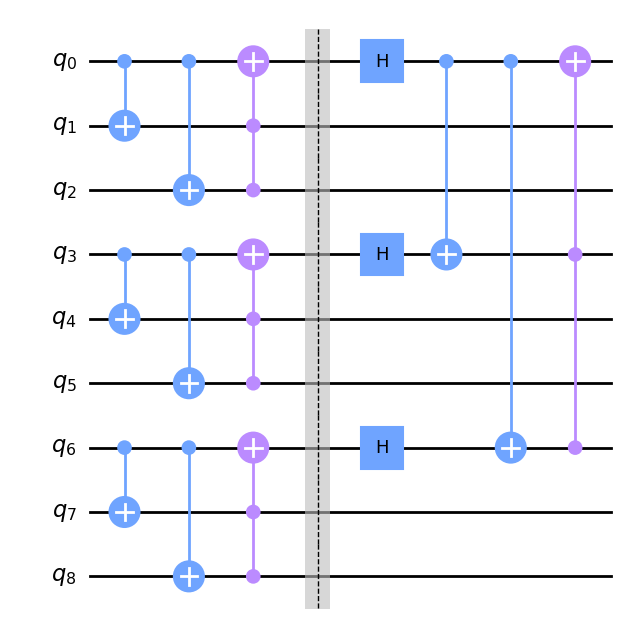

In [168]:
# decoder circuit
decoder = QuantumCircuit(9, name="decoder")

# detect bit flip syndrome and correct
decoder.cx(0,1)
decoder.cx(0,2)
decoder.cx(3,4)
decoder.cx(3,5)
decoder.cx(6,7)
decoder.cx(6,8)
decoder.ccx(1,2,0)
decoder.ccx(4,5,3)
decoder.ccx(7,8,6)

decoder.barrier(range(9))

# detect phase flip syndrome and correct
decoder.h(0)
decoder.h(3)
decoder.h(6)
decoder.cx(0,3)
decoder.cx(0,6)
decoder.ccx(3,6, 0)

decoder.draw('mpl')

## Noisy channel
It's now time for the noisy channel. I'm going to define it accordingly to the Qiskit documentation using the class NoiseModel. Since Shor Code is protecting the qubit from all possible bit-flip and phase-flip continuous and independent errors, these types of errors can be achieved using two gates:
  - X gate for bit-flip with probability `bit_flip_prob`
  - Z gate for phase-flip with probability `phase_flip_prob`

We can define a noise model to be applied on two custom gates achieving the required error model.
Finally we can define a circuit with the two custom bit-flip and phase-flip gates representing the noisy channel, applying them to one of the qubits, randomly choosen.

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['phase-flip', 'bit-flip']
  All-qubits errors: ['bit-flip', 'phase-flip']


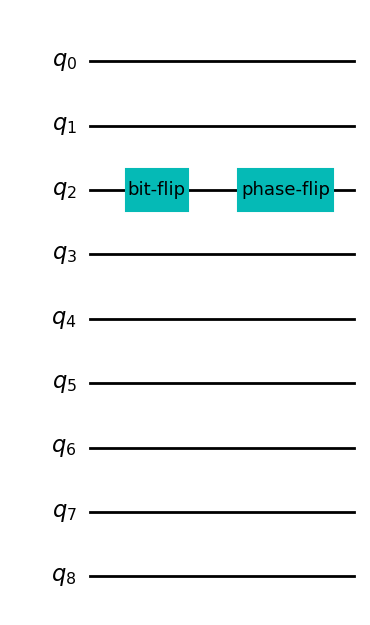

In [169]:
from qiskit_aer.noise import NoiseModel, errors
from qiskit.circuit.library import IGate, XGate, ZGate
import random

# noise model
noise_model = NoiseModel()

x = XGate(label="bit-flip")
bit_flip_prob = 0.6
x_noise_error = [((XGate(), [0]), bit_flip_prob), ((IGate(), [0]), 1 - bit_flip_prob)]
noise_model.add_all_qubit_quantum_error(x_noise_error, ["bit-flip"])

z = ZGate(label="phase-flip")
phase_flip_prob = 0.4
z_noise_error = [((ZGate(), [0]), phase_flip_prob), ((IGate(), [0]), 1 - phase_flip_prob)]
noise_model.add_all_qubit_quantum_error(z_noise_error, ["phase-flip"])

print(noise_model)

# noisy channel circuit
noisy_channel = QuantumCircuit(9, name="noisy channel")

corrupted = random.randint(0,9)

noisy_channel.append(x, [corrupted])
noisy_channel.append(z, [corrupted])

noisy_channel.draw('mpl')

## Final circuit
It's time to put everything together and build the final circuit, which will be composed by:
  1. encoder
  2. noisy-channel
  3. encoder
  4. measurement

If the circuit implementing Shor code is correct, each output should be identical to the input, i.e. detecting and recostructing the possible error.

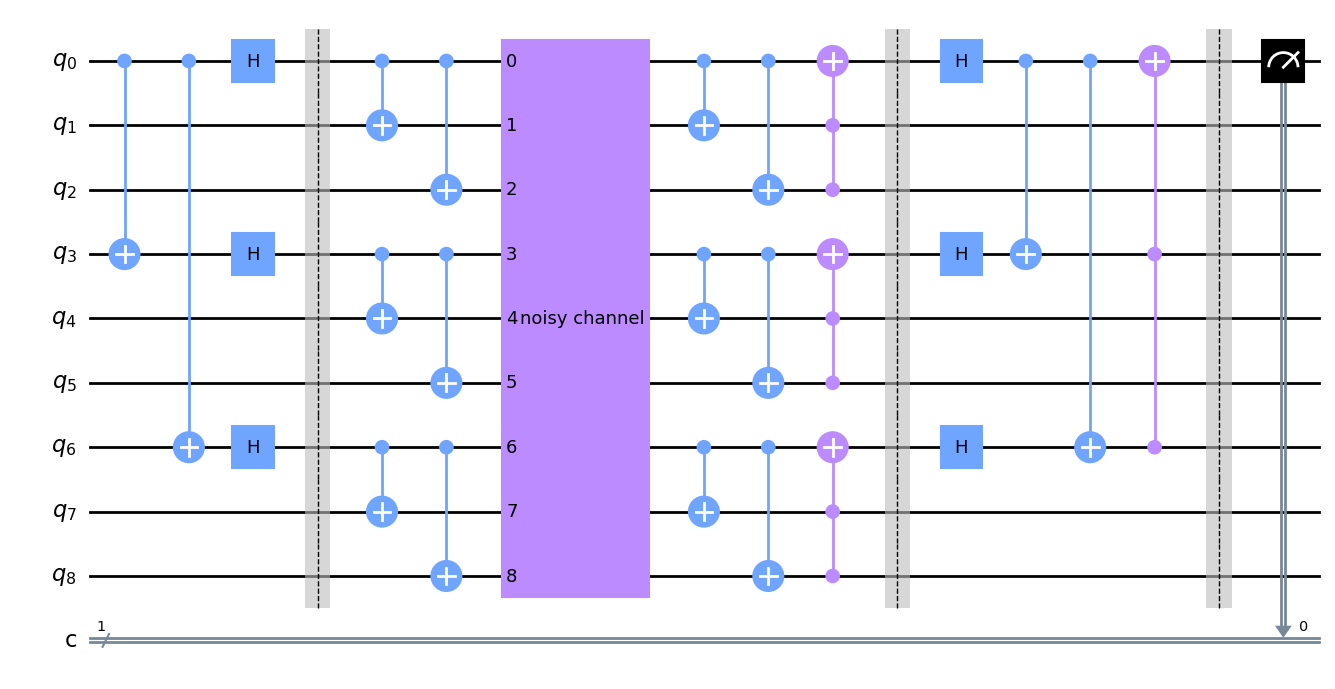

In [170]:
shor = QuantumCircuit(9,1).compose(encoder)\
            .compose(noisy_channel.to_instruction())\
            .compose(decoder)

shor.barrier(range(9))
shor.measure(0, 0)

shor.draw('mpl')

## Simulation
Let's start by simulating the communication over the noisy channel without using the Shor channel.
This one will be composed just by a simple circuit replicating the noisy channel.

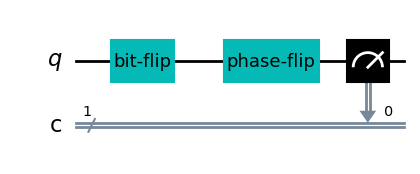

In [171]:
unencoded = QuantumCircuit(1,1)
unencoded.append(x, [0])
unencoded.append(z, [0])
unencoded.measure(0,0)

unencoded.draw('mpl')

First I'll simulate the circuit by sending |0> and then sending |1>

{'1': 428, '0': 596}


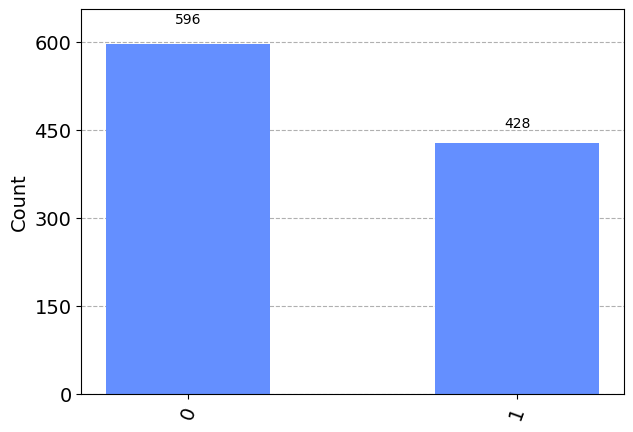

In [172]:
backend = QasmSimulator()

compiled_unencoded = transpile(unencoded, backend)
counts = backend.run(compiled_unencoded, noise_model=noise_model).result().get_counts()
print(counts)
plot_histogram(counts)

{'0': 398, '1': 626}


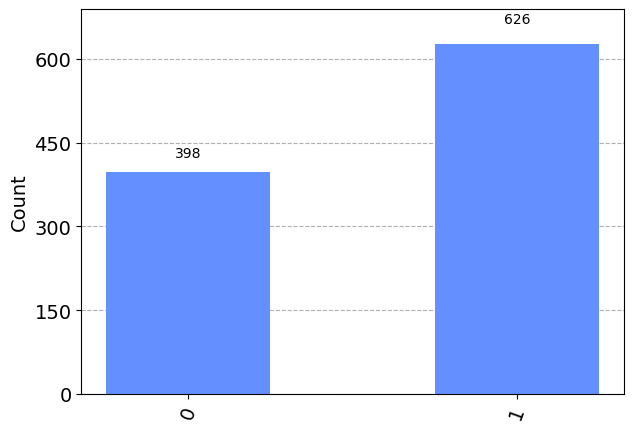

In [173]:
unencoded_one = QuantumCircuit(1,1)
unencoded_one.x(0)
unencoded_one = unencoded_one.compose(unencoded)
unencoded_one.draw('mpl')

compiled_unencoded = transpile(unencoded_one, backend)
counts = backend.run(compiled_unencoded, noise_model=noise_model).result().get_counts()
print(counts)
plot_histogram(counts)

Let's now simulate the trasmission over the noisy channel using the Shor error correcting code. Again first by sending |0> and then |1>.

{'0': 1024}


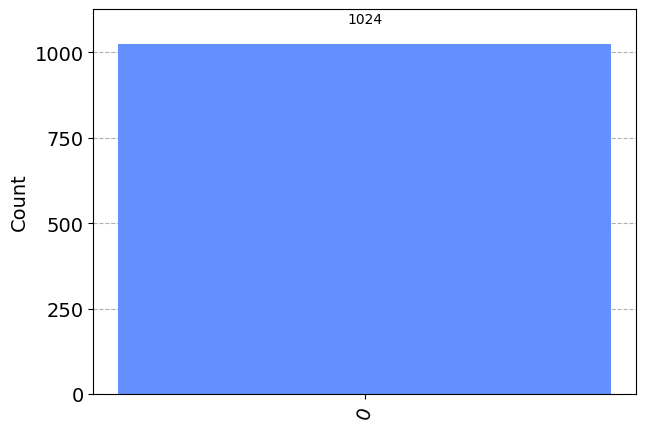

In [174]:
compiled_shor = transpile(shor, backend)
counts = backend.run(compiled_shor, noise_model=noise_model).result().get_counts()
print(counts)
plot_histogram(counts)

{'1': 1024}


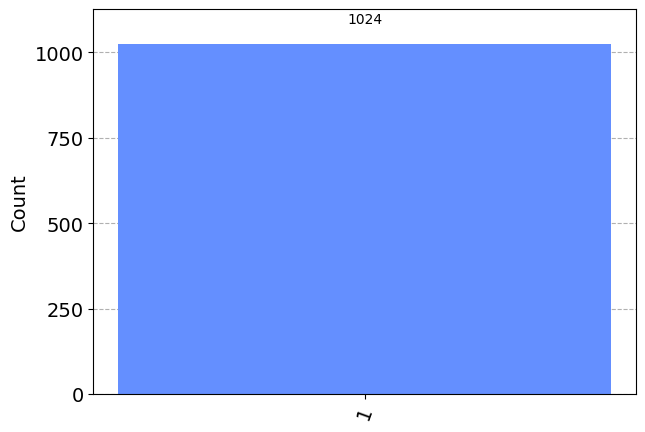

In [175]:
shor_one = QuantumCircuit(9,1)
shor_one.x(0)
shor_one = shor_one.compose(shor)
shor_one.draw('mpl')

compiled_shor_one = transpile(shor_one, backend)
counts = backend.run(compiled_shor_one, noise_model=noise_model).result().get_counts()
print(counts)
plot_histogram(counts)

## Conclusions
As we can see in both cases the Shor error correcting code is able to reconstruct the original states correctly. Even if corrupted by a noisy channel which will lead to an meaningless state without the usage of the Shor code.